In [1]:
from torch.utils.data import Dataset
import torch
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import pandas as pd
import torch
import random
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader
from sklearn.decomposition import PCA
import matplotlib.colors as mcolors
from random import randint
from augment_functions import (
    random_mask,
    resize_encoder,
    augment_sample,
    augment_sample_random_mask,
)
from sklearn.metrics.pairwise import pairwise_distances

In [2]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
random.seed(42)
g = torch.Generator()
g.manual_seed(42)

In [3]:
def random_mask(sample, mask_prob=0.7):
    random_tensor = torch.rand(sample.shape, device=sample.device)
    mask = (random_tensor > mask_prob).float()
    masked_image = sample * mask
    return masked_image


class WeatherBenchDataset(Dataset):
    def __init__(self, data, mask_prob=0.7):
        self.data = data
        self.mask_prob = mask_prob

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        x_orig = self.data[idx]
        x = resize_encoder(x_orig)
        masked_x = random_mask(x, mask_prob=self.mask_prob)
        masked_x_0_5 = random_mask(x, mask_prob=0.5)
        masked_x_0_3 = random_mask(x, mask_prob=0.3)
        y = idx
        return x_orig, x, masked_x, masked_x_0_3, masked_x_0_5, y

In [4]:
model = torch.load(
    "det_autoencoder.pth", weights_only=False, map_location=DEVICE
)
model.eval()

model = model.encoder

BATCH_SIZE = 20
data = torch.load("/vol/bitbucket/nb324/ERA5_64x32_daily_850.pt")
n_samples = data.shape[0]
n_train = int(n_samples * 0.6)
n_valid = int(n_samples * 0.2)
train_data = data[:n_train]
valid_data = data[n_train : n_train + n_valid]
test_data = data[n_train + n_valid :]

mean = train_data.mean(dim=(0, 2, 3), keepdim=True)
std = train_data.std(dim=(0, 2, 3), keepdim=True)

train_data = (train_data - mean) / std
test_dataset = WeatherBenchDataset(data=train_data, mask_prob=0.7)
trainloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

test_data = (test_data - mean) / std
test_dataset = WeatherBenchDataset(data=test_data, mask_prob=0.7)
testloader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True, generator=g
)

In [5]:
def negative_cosine_sim_matrix(embeddings):
    z = F.normalize(embeddings, dim=1)
    sim_matrix = torch.matmul(z, z.T)
    N = sim_matrix.shape[0]
    mask = ~torch.eye(N, dtype=torch.bool, device=sim_matrix.device)
    negative_sims = sim_matrix[mask]
    return negative_sims

In [6]:
cos_sim_mean = []
rand_cos_sim_mean = []
mean_var = []
with torch.no_grad():
    for batch in testloader:
        X = batch[1].to(DEVICE)
        X_prime = batch[2].to(DEVICE)
        embeddings_x, _ = model(X)
        embeddings_x_prime, _ = model(X_prime)

        embeddings_x = embeddings_x.cpu()
        embeddings_x_prime = embeddings_x_prime.cpu()

        cos_sim = F.cosine_similarity(embeddings_x, embeddings_x_prime, dim=1)
        cos_sim_mean.append(cos_sim.mean().item())

        neg_cosine = negative_cosine_sim_matrix(embeddings_x)
        rand_cos_sim_mean.append(neg_cosine.mean().item())

        variance = embeddings_x.var(dim=0)
        mean_var.append(variance.mean().item())

cos_sim, rand_cos_sim, mean_var = (
    np.mean(cos_sim_mean),
    np.mean(rand_cos_sim_mean),
    np.mean(mean_var),
)

print("Mean Cosine similarity:", cos_sim)
print("Negative Mean Cosine similarity:", rand_cos_sim)
print("Mean Variance of Embeddings", mean_var)

Mean Cosine similarity: 0.991828398572074
Negative Mean Cosine similarity: 0.2727659261888928
Mean Variance of Embeddings 0.020270049571990967


In [7]:
# Grab a random batch
batch = list(testloader)[0]

batch = next(iter(testloader))

x = batch[1].to(DEVICE)
masked_x = batch[2].to(DEVICE)
masked_x_0_3 = batch[3].to(DEVICE)
masked_x_0_5 = batch[4].to(DEVICE)
y = batch[5].to(DEVICE)

print(x.shape)

torch.Size([20, 5, 144, 72])


In [8]:
with torch.no_grad():
    embeddings_x, _ = model(x)
    embeddings_masked_x, _ = model(masked_x)
    embeddings_masked_x_0_3, _ = model(masked_x_0_3)
    embeddings_masked_x_0_5, _ = model(masked_x_0_5)

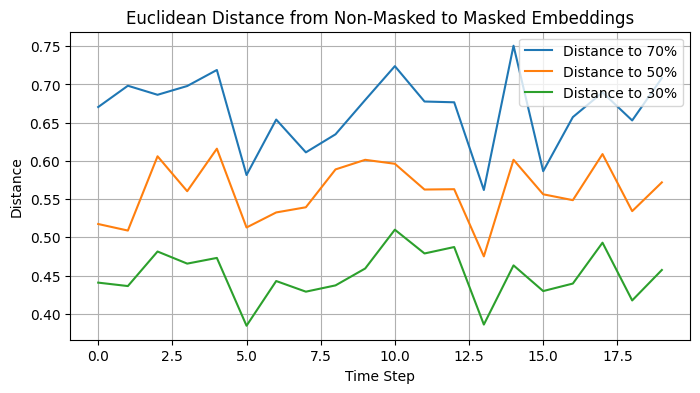

In [9]:
embeddings_x = embeddings_x.cpu()
embeddings_masked_x = embeddings_masked_x.cpu()
embeddings_masked_x_0_5 = embeddings_masked_x_0_5.cpu()
embeddings_masked_x_0_3 = embeddings_masked_x_0_3.cpu()
dist = np.linalg.norm(embeddings_x - embeddings_masked_x, axis=1)
dist2 = np.linalg.norm(embeddings_x - embeddings_masked_x_0_5, axis=1)
dist1 = np.linalg.norm(embeddings_x - embeddings_masked_x_0_3, axis=1)
plt.figure(figsize=(8, 4))
plt.plot(dist, label="Distance to 70%")
plt.plot(dist2, label="Distance to 50%")
plt.plot(dist1, label="Distance to 30%")
plt.title(f"Euclidean Distance from Non-Masked to Masked Embeddings")
plt.xlabel("Time Step")
plt.ylabel("Distance")
plt.legend()
plt.grid(True)
plt.show()

In [10]:
embeddings_x = embeddings_x.cpu().numpy()
embeddings_masked_x = embeddings_masked_x.cpu().numpy()
embeddings_masked_x_0_3 = embeddings_masked_x_0_3.cpu().numpy()
embeddings_masked_x_0_5 = embeddings_masked_x_0_5.cpu().numpy()
y = y.cpu().numpy()

combined = np.vstack(
    [
        embeddings_x,
        embeddings_masked_x,
        embeddings_masked_x_0_3,
        embeddings_masked_x_0_5,
    ]
)
pca = PCA(n_components=2)
combined_proj = pca.fit_transform(combined)

x_proj = combined_proj[: len(embeddings_x)]
x_prime_proj = combined_proj[len(embeddings_x) : len(embeddings_x) * 2]
x_prime_proj_0_3 = combined_proj[
    len(embeddings_x) * 2 : len(embeddings_x) * 3
]
x_prime_proj_0_5 = combined_proj[
    len(embeddings_x) * 3 : len(embeddings_x) * 4
]

In [11]:
df = pd.DataFrame(
    {
        "x": np.concatenate(
            [
                x_proj[:, 0],
                x_prime_proj_0_3[:, 0],
                x_prime_proj_0_5[:, 0],
                x_prime_proj[:, 0],
            ]
        ),
        "y": np.concatenate(
            [
                x_proj[:, 1],
                x_prime_proj_0_3[:, 1],
                x_prime_proj_0_5[:, 1],
                x_prime_proj[:, 1],
            ]
        ),
        "group": ["No Mask"] * BATCH_SIZE
        + ["30% Mask"] * BATCH_SIZE
        + ["50% Mask"] * BATCH_SIZE
        + ["70% Mask"] * BATCH_SIZE,
        "point_id": list(range(BATCH_SIZE)) * 4,
        "labels": list(y) * 4,
    }
)

/tmp/ipykernel_1434339/4244481902.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', len(unique_labels))


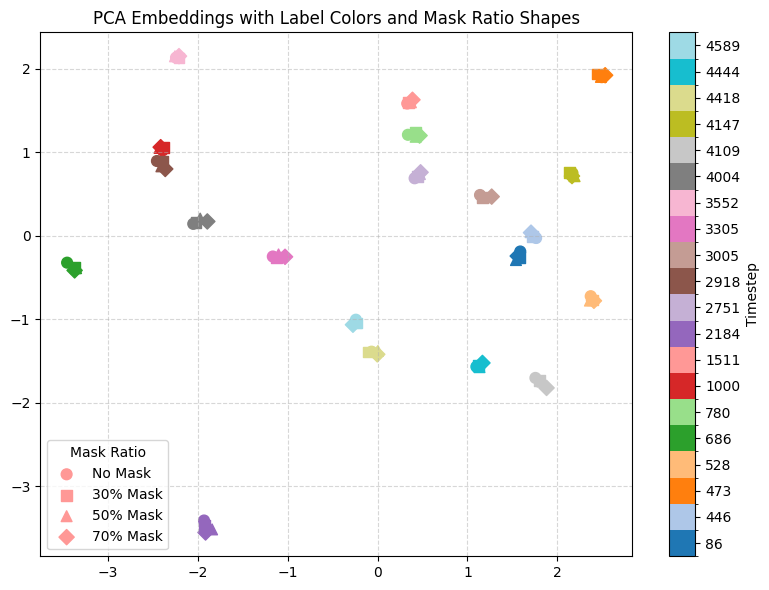

In [12]:
unique_labels = sorted(df["labels"].unique())
label_to_int = {label: i for i, label in enumerate(unique_labels)}
df["label_int"] = df["labels"].map(label_to_int)

cmap = plt.cm.get_cmap("tab20", len(unique_labels))
norm = mcolors.BoundaryNorm(
    np.arange(-0.5, len(unique_labels) + 0.5), len(unique_labels)
)


markers = {"No Mask": "o", "30% Mask": "s", "50% Mask": "^", "70% Mask": "D"}

plt.figure(figsize=(8, 6))

for group, marker in markers.items():
    group_data = df[df["group"] == group]
    plt.scatter(
        group_data["x"],
        group_data["y"],
        c=group_data["label_int"],
        cmap=cmap,
        norm=norm,
        marker=marker,
        s=60,
        label=f"{group}",
    )

cbar = plt.colorbar(ticks=np.arange(len(unique_labels)))
cbar.set_label("Timestep")
cbar.ax.set_yticklabels(unique_labels)

plt.title("PCA Embeddings with Label Colors and Mask Ratio Shapes")
plt.legend(title="Mask Ratio")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [13]:
BATCH_SIZE = 256
data = torch.load("/vol/bitbucket/nb324/ERA5_64x32_daily_850.pt")
n_samples = data.shape[0]
n_train = int(n_samples * 0.6)
n_valid = int(n_samples * 0.2)
train_data = data[:n_train]
valid_data = data[n_train : n_train + n_valid]
test_data = data[n_train + n_valid :]

mean = train_data.mean(dim=(0, 2, 3), keepdim=True)
std = train_data.std(dim=(0, 2, 3), keepdim=True)

train_data = (train_data - mean) / std
test_dataset = WeatherBenchDataset(data=train_data, mask_prob=0.7)
trainloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

test_data = (test_data - mean) / std
test_dataset = WeatherBenchDataset(data=test_data, mask_prob=0.7)
testloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [14]:
# Grab a random batch
batch = list(testloader)[0]

batch = next(iter(testloader))

x = batch[1].to(DEVICE)
masked_x = batch[2].to(DEVICE)
masked_x_0_3 = batch[3].to(DEVICE)
masked_x_0_5 = batch[4].to(DEVICE)
y = batch[5].to(DEVICE)

print(x.shape)

torch.Size([256, 5, 144, 72])


In [15]:
with torch.no_grad():
    embeddings_masked_x, _ = model(masked_x)
embeddings_masked_x = embeddings_masked_x.cpu()

In [16]:
embeddings_masked_x_np = embeddings_masked_x.cpu().numpy()
y = y.cpu().numpy()

pca = PCA(n_components=2)
x_proj = pca.fit_transform(embeddings_masked_x_np)

In [17]:
df = pd.DataFrame({"x": x_proj[:, 0], "y": x_proj[:, 1], "labels": y})

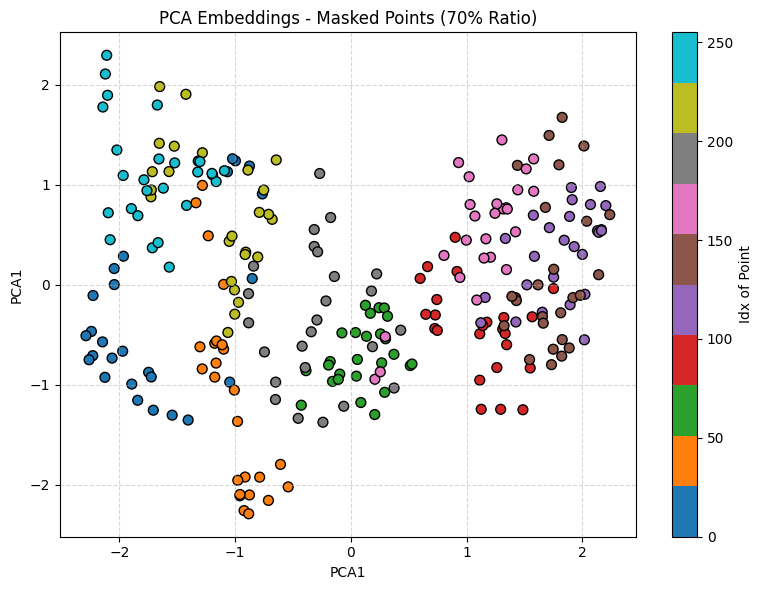

In [18]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    df["x"], df["y"], c=df["labels"], cmap="tab10", s=50, edgecolors="k"
)
plt.xlabel("PCA1")
plt.ylabel("PCA1")
plt.title("PCA Embeddings - Masked Points (70% Ratio)")
plt.colorbar(scatter, label="Idx of Point")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [19]:
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score

import numpy as np

range_k = [4, 8, 12, 16, 24, 32]
nmi_scores = []
for k in range_k:
    temp_labels = np.arange(BATCH_SIZE) // (BATCH_SIZE // k)
    clust_labels = KMeans(n_clusters=k).fit_predict(embeddings_masked_x_np)
    nmi_scores.append(normalized_mutual_info_score(temp_labels, clust_labels))

print(nmi_scores)

[np.float64(0.43549392558268135), np.float64(0.5476968714502141), np.float64(0.6345805130938608), np.float64(0.668175745234005), np.float64(0.7278977172974608), np.float64(0.7477722826853886)]


In [20]:
cosine_sims = [
    F.cosine_similarity(
        embeddings_masked_x[i + 1], embeddings_masked_x[i], dim=0
    )
    .cpu()
    .numpy()
    for i in range(len(embeddings_masked_x) - 1)
]
print(f"Mean Step Distances: {np.mean(cosine_sims):.4f}")

Mean Step Distances: 0.7811


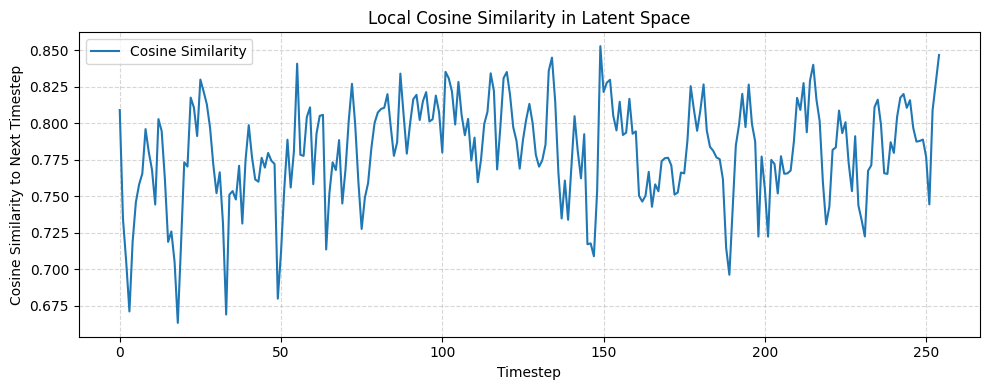

In [21]:
plt.figure(figsize=(10, 4))
plt.plot(cosine_sims, label="Cosine Similarity")
plt.xlabel("Timestep")
plt.ylabel("Cosine Similarity to Next Timestep")
plt.title("Local Cosine Similarity in Latent Space")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

In [22]:
step_dists = [
    np.linalg.norm(embeddings_masked_x_np[i + 1] - embeddings_masked_x_np[i])
    ** 2
    for i in range(len(embeddings_masked_x_np) - 1)
]
print(f"Mean Step Distances: {np.mean(step_dists):.4f}")

Mean Step Distances: 12.6064


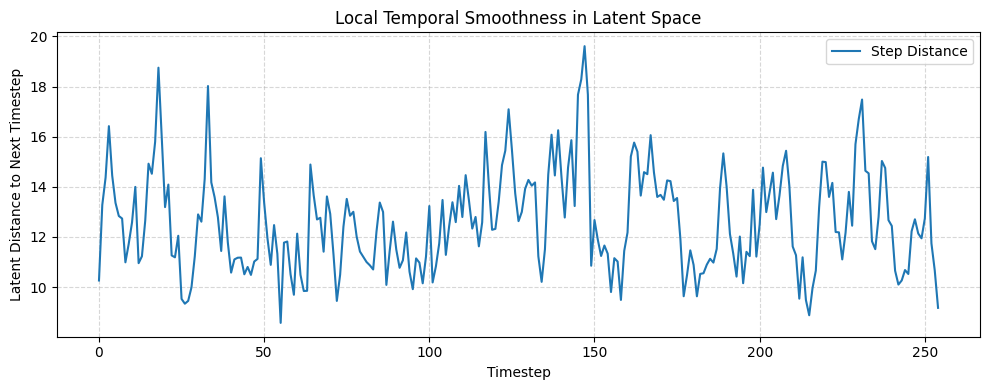

In [23]:
plt.figure(figsize=(10, 4))
plt.plot(step_dists, label="Step Distance")
plt.xlabel("Timestep")
plt.ylabel("Latent Distance to Next Timestep")
plt.title("Local Temporal Smoothness in Latent Space")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

In [24]:
cycle_dists = [
    np.linalg.norm(
        embeddings_masked_x_np[i + 1]
        - 2 * embeddings_masked_x_np[i]
        + embeddings_masked_x_np[i - 1]
    )
    ** 2
    for i in range(1, len(embeddings_masked_x_np) - 1)
]
print("Mean Cycle Distance:", np.mean(cycle_dists))

Mean Cycle Distance: 27.466457


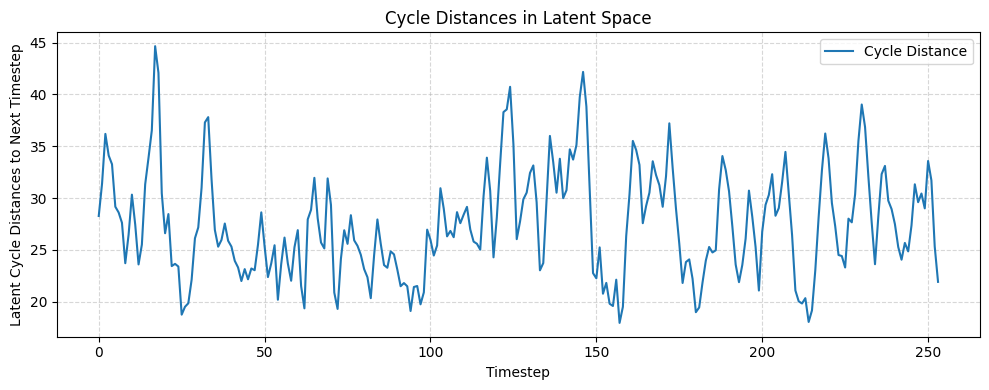

In [25]:
plt.figure(figsize=(10, 4))
plt.plot(cycle_dists, label="Cycle Distance")
plt.xlabel("Timestep")
plt.ylabel("Latent Cycle Distances to Next Timestep")
plt.title("Cycle Distances in Latent Space")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

In [26]:
step_series = pd.Series(step_dists)
autocorr = step_series.autocorr(lag=1)
print(f"Autocorrelation of step distances (lag=1): {autocorr:.3f}")

Autocorrelation of step distances (lag=1): 0.671


In [27]:
# Train a neural ODE
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
from neural_ode.neural_ode_model import (
    NeuralODE,
    LatentTestDataset,
    train_neural_ode,
)

# Encode the data
encoded_data_list = []
with torch.no_grad():
    for batch in testloader:
        masked_x = batch[2].to(DEVICE)
        encoded_data, _ = model(masked_x)
        encoded_data_list.append(encoded_data)

encoded_data_list = torch.cat(encoded_data_list, dim=0)

encoded_dataset = LatentTestDataset(
    data=encoded_data_list, context_length=BATCH_SIZE, stride=1
)
encoded_dataloder = DataLoader(
    encoded_dataset, batch_size=BATCH_SIZE, shuffle=True
)

neural_model = NeuralODE(dim=encoded_data_list.shape[1]).to(DEVICE)
optimizer = torch.optim.Adam(neural_model.parameters(), lr=1e-2)
loss_fn = torch.nn.MSELoss()

neural_model = train_neural_ode(
    10,
    model=neural_model,
    trainloader=encoded_dataloder,
    optimizer=optimizer,
    loss_fn=loss_fn,
    device=DEVICE,
)

Epoch: 1, Train Loss: 0.0578
Epoch: 2, Train Loss: 0.0399
Epoch: 3, Train Loss: 0.0370
Epoch: 4, Train Loss: 0.0367
Epoch: 5, Train Loss: 0.0354
Epoch: 6, Train Loss: 0.0347
Epoch: 7, Train Loss: 0.0345
Epoch: 8, Train Loss: 0.0342
Epoch: 9, Train Loss: 0.0337
Epoch: 10, Train Loss: 0.0332


In [28]:
# Grab a random batch
batch = list(testloader)[0]

batch = next(iter(testloader))

x = batch[1].to(DEVICE)
masked_x = batch[2].to(DEVICE)
masked_x_0_3 = batch[3].to(DEVICE)
masked_x_0_5 = batch[4].to(DEVICE)
y = batch[5].to(DEVICE)

print(x.shape)

torch.Size([256, 5, 144, 72])


In [29]:
with torch.no_grad():
    embeddings_masked_x, _ = model(masked_x)
# embeddings_masked_x =embeddings_masked_x.cpu()

In [30]:
odefunc = neural_model.odefunc
odefunc.eval()
speeds = []

z_seq = embeddings_masked_x
t_seq = torch.linspace(0, 1, steps=z_seq.shape[0]).to(z_seq.device)

with torch.no_grad():
    for t_i, z_i in zip(t_seq, z_seq):
        v_i = odefunc(t_i, z_i.unsqueeze(0))
        speed = v_i.norm(dim=1).item()
        speeds.append(speed)

speeds = np.array(speeds)
print(f"Speed Mean: {speeds.mean()}")
print(f"Speed Variance: {speeds.var()}")

Speed Mean: 9.961297190748155
Speed Variance: 5.949774399884616


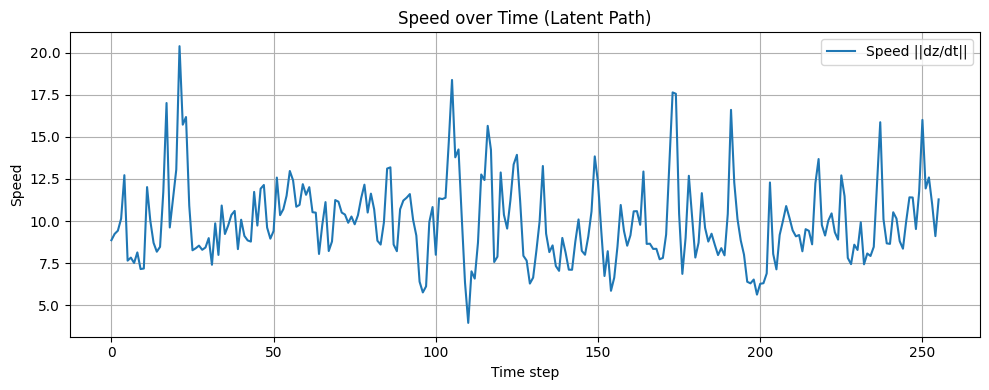

In [31]:
plt.figure(figsize=(10, 4))
plt.plot(np.arange(BATCH_SIZE), speeds, label="Speed ||dz/dt||")
plt.xlabel("Time step")
plt.ylabel("Speed")
plt.title("Speed over Time (Latent Path)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [32]:
curvatures = []

for i in range(len(t_seq)):
    d2f_dt2 = torch.zeros(z_seq.shape[1])
    t = t_seq[i].clone().detach().requires_grad_(True)
    z = z_seq[i].clone().detach().requires_grad_(True)
    f = odefunc(t, z.unsqueeze(0))[0]
    d2f_dt2 = torch.stack(
        [
            torch.autograd.grad(f[j], t, create_graph=True)[0]
            for j in range(f.shape[0])
        ]
    )
    curvatures.append(d2f_dt2.norm().item())
curvatures = np.array(curvatures)

In [33]:
print(f"Mean curvatures: {curvatures.mean()}")
print(f"Variance of curvatures: {curvatures.var()}")

Mean curvatures: 0.5803839305299334
Variance of curvatures: 0.050287713892310404


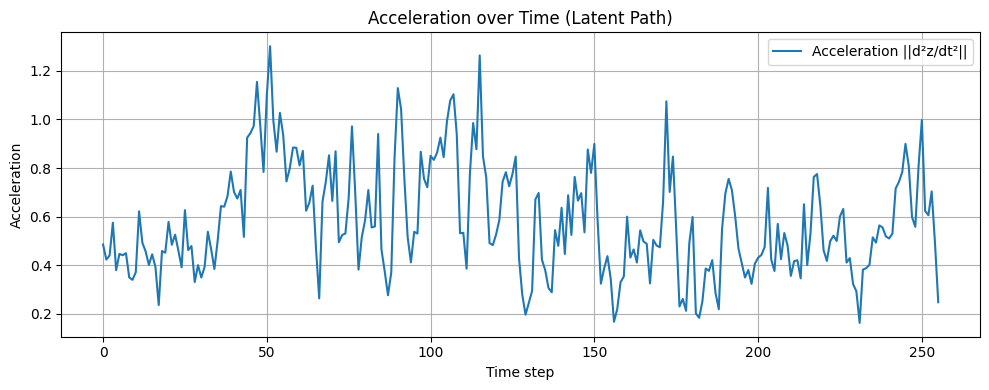

In [34]:
plt.figure(figsize=(10, 4))
plt.plot(np.arange(BATCH_SIZE), curvatures, label="Acceleration ||d²z/dt²||")
plt.xlabel("Time step")
plt.ylabel("Acceleration")
plt.title("Acceleration over Time (Latent Path)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [35]:
jerk = []
for i in range(len(t_seq)):
    print(i)
    t = t_seq[i].clone().detach().requires_grad_()
    z = z_seq[i].clone().detach().requires_grad_()
    f = odefunc(t, z.unsqueeze(0))[0]
    # Check if f depends on t
    if torch.autograd.grad(f[0], t, create_graph=True)[0].abs().sum() == 0:
        print(
            "Warning: odefunc does not depend on t. All derivatives will be zero."
        )

    d3f_dt3 = []
    for j in range(f.shape[0]):
        d2f_dt2_j = torch.autograd.grad(f[j], t, create_graph=True)[0]
        # print(d2f_dt2_j)
        d3f_dt3_j = torch.autograd.grad(d2f_dt2_j, t, create_graph=True)[0]
        d3f_dt3.append(d3f_dt3_j)
    d3f_dt3 = torch.stack(d3f_dt3)

    jerk.append(d3f_dt3.norm().item())

jerk = np.array(jerk)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255


In [36]:
print(f"Mean jerk: {jerk.mean()}")
print(f"Variance of jerk: {jerk.var()}")

Mean jerk: 0.04949431509885471
Variance of jerk: 0.0005584076365599874


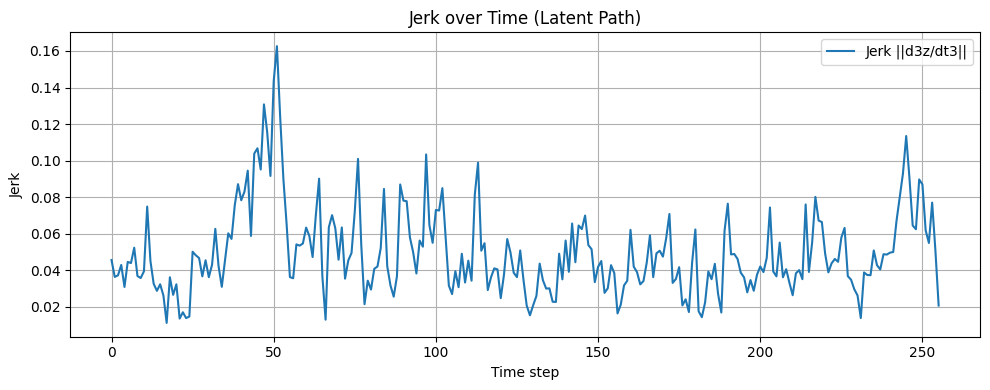

In [37]:
plt.figure(figsize=(10, 4))
plt.plot(np.arange(BATCH_SIZE), jerk, label="Jerk ||d3z/dt3||")
plt.xlabel("Time step")
plt.ylabel("Jerk")
plt.title("Jerk over Time (Latent Path)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [40]:
# Smoothness Metrics: https://www.researchgate.net/publication/375512061_Trade-offs_in_the_latent_representation_of_microstructure_evolution

V = encoded_data_list[1:] - encoded_data_list[:-1]
S = torch.sign(V)
same_sign = (S[1:] == S[:-1]).float()
C_t = same_sign.mean(dim=1)
M1 = C_t.mean()


v1 = V[:-1]
v2 = V[1:]
cos_sim = F.cosine_similarity(v1, v2, dim=1)
cos_sim = torch.clamp(cos_sim, -1.0, 1.0)
alpha_t = torch.acos(cos_sim)
M2 = alpha_t.mean()

In [ ]:
print(f"Metric 1: {M1.item()}")
print(f"Metric 2: {M2.item()}")

Metric 1: 0.4772588610649109
Metric 2: 1.65928053855896


: 